# eCommerce Predict Repurchase 

In this project, I utilized data from an eCommerce platform __[link](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)__ to predict repurchase. The project comprises four main parts:

Part 1 - Data Exploration: This involves visualization and quality checks of the data.

Part 2 - ETL (Extract, Transform, Load): Tasks include creating a Postgres database, feature engineering, and loading data for modeling in SQL.

Part 3 - Data Preprocessing and Modeling: Utilizing techniques such as XGBoost and Random Forest to preprocess the data and build predictive models.

Part 4 - Business Recommendations: Providing actionable insights and recommendations based on the analysis and modeling results.

# Part 4 

# summary of my recommendation based on my SQL analysis below.
1. send repurchase notification during a week period. Most repurchase happens on Sunday, Monday, and Saturday,  9am-4pm.
2. most repurchased items were placed in cart first, therefore I recommend to push recommended items at the top of the cart page at the early stage of shopping journey.
3. Based on the most repurchased & least repurchased items - promote items that are highly associated with the most repurchased items.
4. Based on the most purchased and least purchased items for each department - optimize stock strategy (stock more popular items)

In [63]:
import pandas as pd
from pandasql import sqldf
import numpy as np

aisles = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\aisles.csv')
departments = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\departments.csv')
order_products_prior = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_prior.csv')
order_products_train = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\order_products_train.csv')
orders = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\orders.csv')
products = pd.read_csv(r'C:\Users\shenl\OneDrive\Documents\eCommerce DS project\products.csv')

## 1. How long does it take for a repurchase - 7 days and 30 days

Recommendation - send notification to those repurchase customer during the first week or 

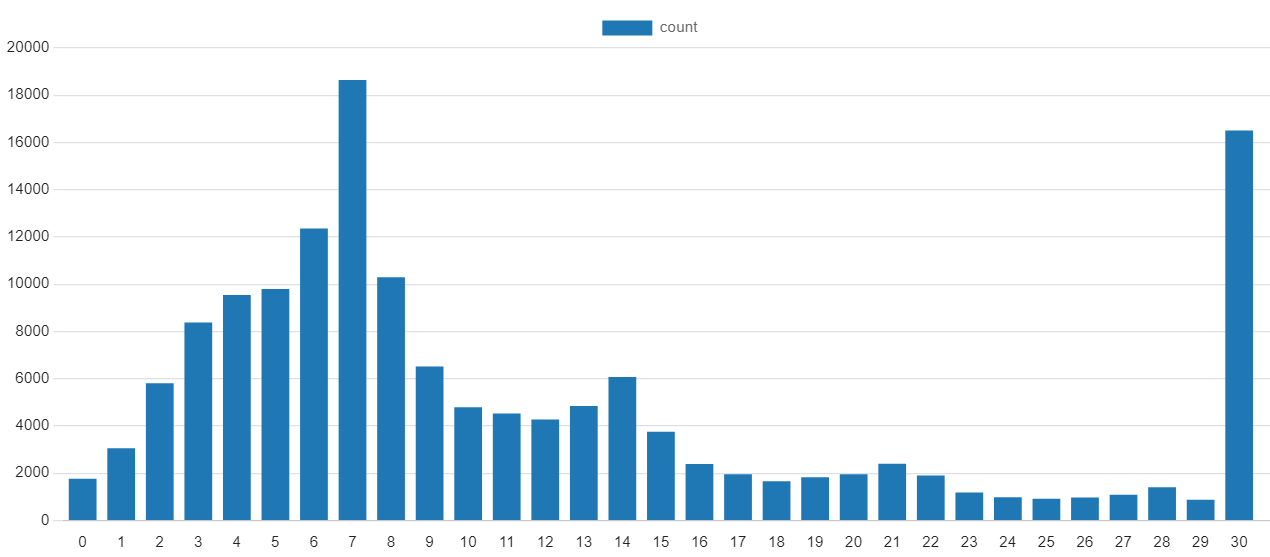

select days_since_prior_order, count(*)
from "Ecommerce_Project".model_data
where target = 1
group by days_since_prior_order

### 1.1 most repurchase happens on Sunday, followed by Monday and Saturday
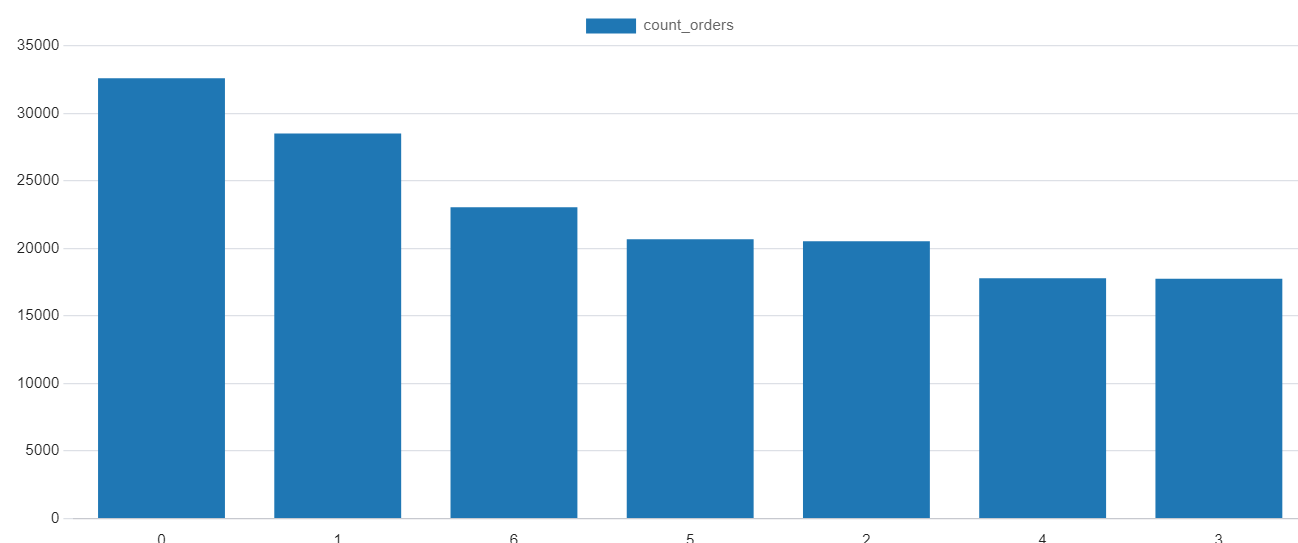


select order_dow, count(*) count_orders
from "Ecommerce_Project".model_data
where target = 1
group by order_dow
order by count_orders desc

### 1.2 most repurchase happens on 9am - 4pm
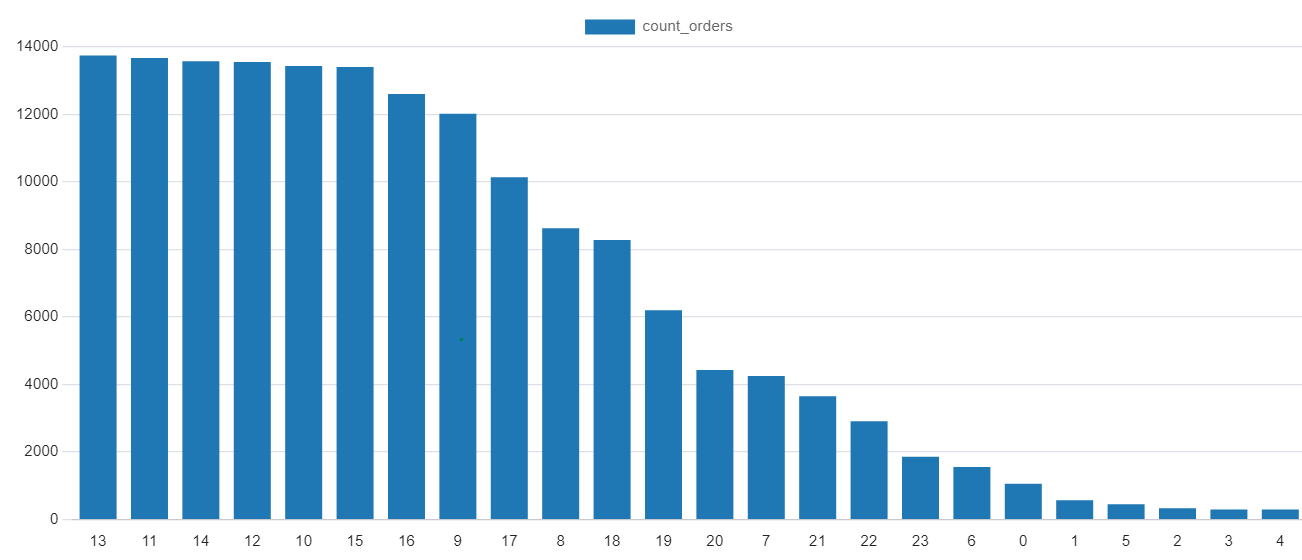
select order_hour_of_day, count(*) count_orders
from "Ecommerce_Project".model_data
where target = 1
group by order_hour_of_day
order by count_orders desc

### 1.2 From EDA, we know most orders happens during the peak days and hours 
recommendaton - send coupons during Monday and Sunday & 8am-6pm to boost sales


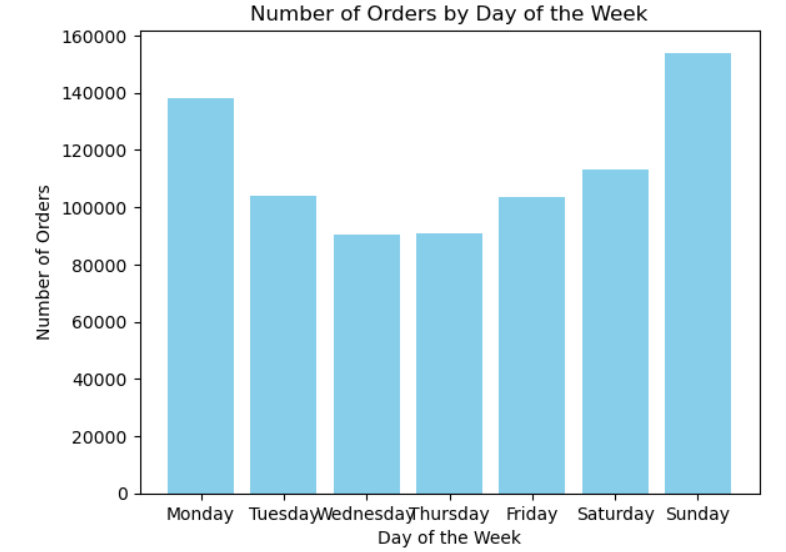

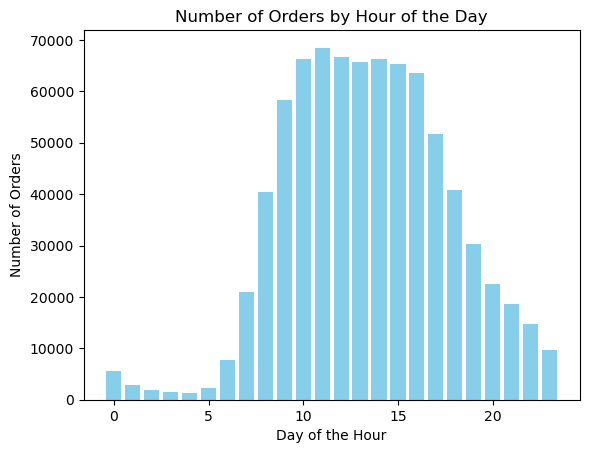

# 2.Most repurchased items are placed in cart first
Products placed 1th-7th in cart are the products mostly reordered.

recommendation - During the early stage of a customer's shopping journey, everytime he placed an item int the cart (especiallly during the first 7 items), push recommended items at the top of the cart page so that customers can pay attention during the early stage of their shopping journey and increase the chances of purchasing.

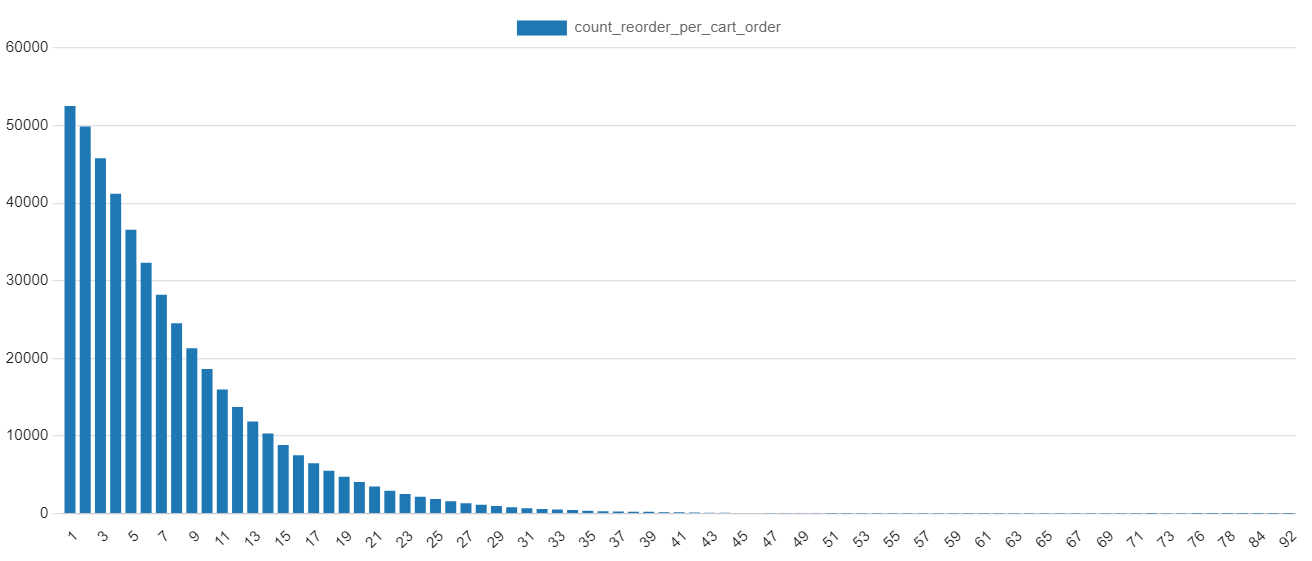

select add_to_cart_order, count(*) count_reorder_per_cart_order
from "Ecommerce_Project".order_products_prior
where reordered = 1
group by add_to_cart_order

# 3. Popular repurchaing items per department
### 3.1 most repurchased item in beverage department (example of beverage department)

recommendation - recommend items that are highly associated with the most repurchased items to increase sales. (juice & cough syrup, beer & diapers)

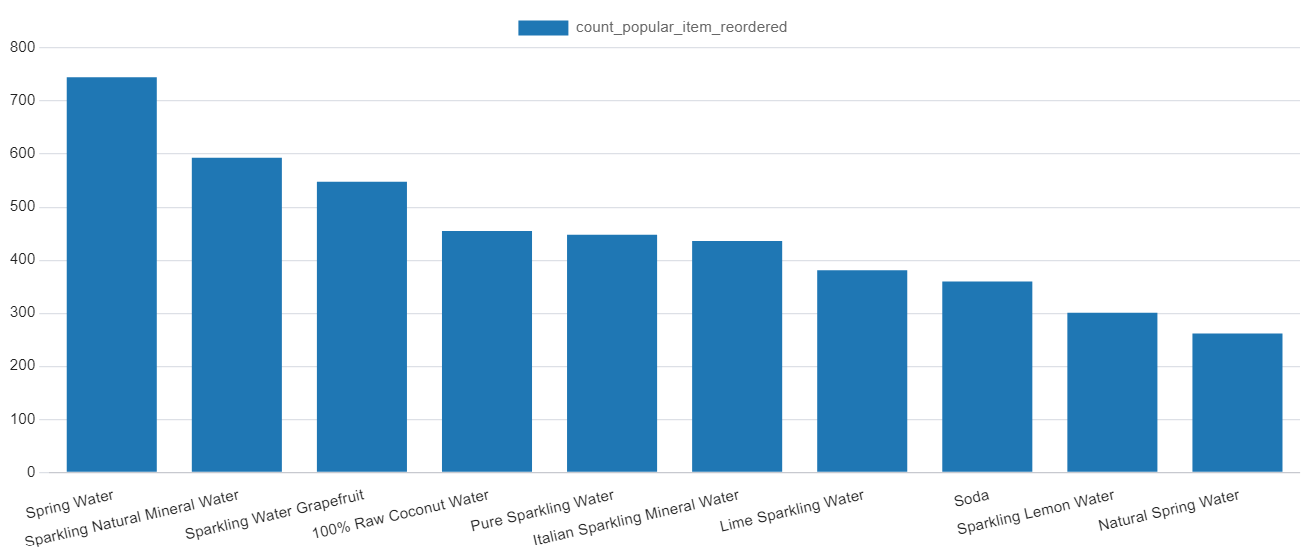

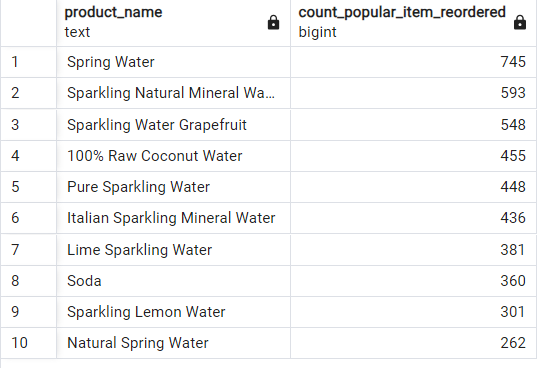


select p.product_name, count(*) count_popular_item_reordered
from "Ecommerce_Project".model_data_department_product m
join "Ecommerce_Project".products p
on m.product_id = p.product_id
where target = 1 and m.department_x = 'beverages'
group by p.product_name
order by count_popular_item_reordered desc
limit 10


### 3.2 most purchased & least purchased items within each department (stock more popular items)

recommendation - stock more popular items, and run promotion of least sold items (and stock less)

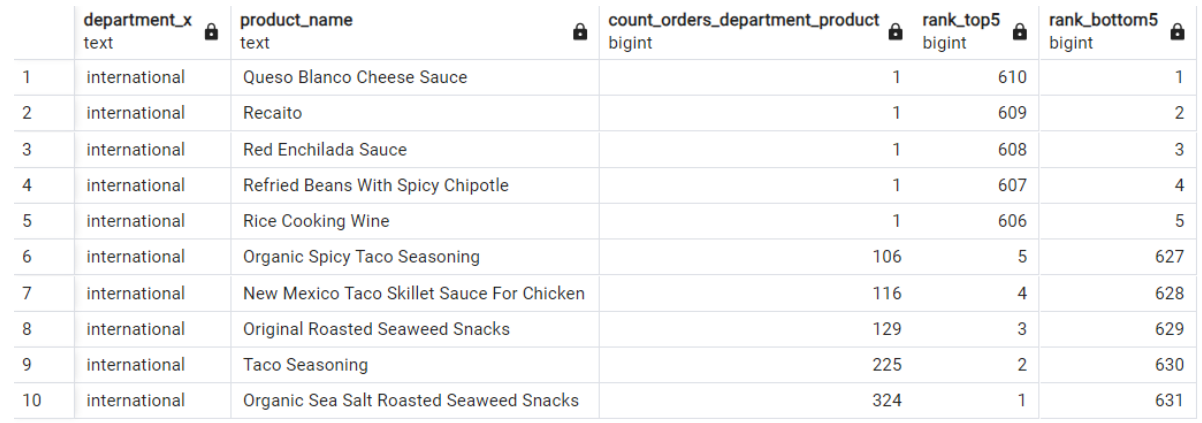

with CTE1 as (
select m.department_x, p.product_name, count(*) count_orders_department_product
from "Ecommerce_Project".model_data_department_product m
join "Ecommerce_Project".products p
on m.product_id = p.product_id
group by m.department_x, p.product_name
order by m.department_x
)

select *
from (select department_x,
    		product_name,
    		count_orders_department_product,
			row_number() over (partition by department_x order by count_orders_department_product desc) rank_top5,
			row_number() over (partition by department_x order by count_orders_department_product) rank_bottom5
from CTE1
where department_x = 'international') as tmp
where rank_top5 <=5 or rank_bottom5 <= 5 

# 4. how many orders does it take for a repurchase
1.2% repurchase orders have 3 previous orders (max)
lots of repurchase takes 1-13 orders

recommendation- when we start to see repurchase pattern, send coupons asap


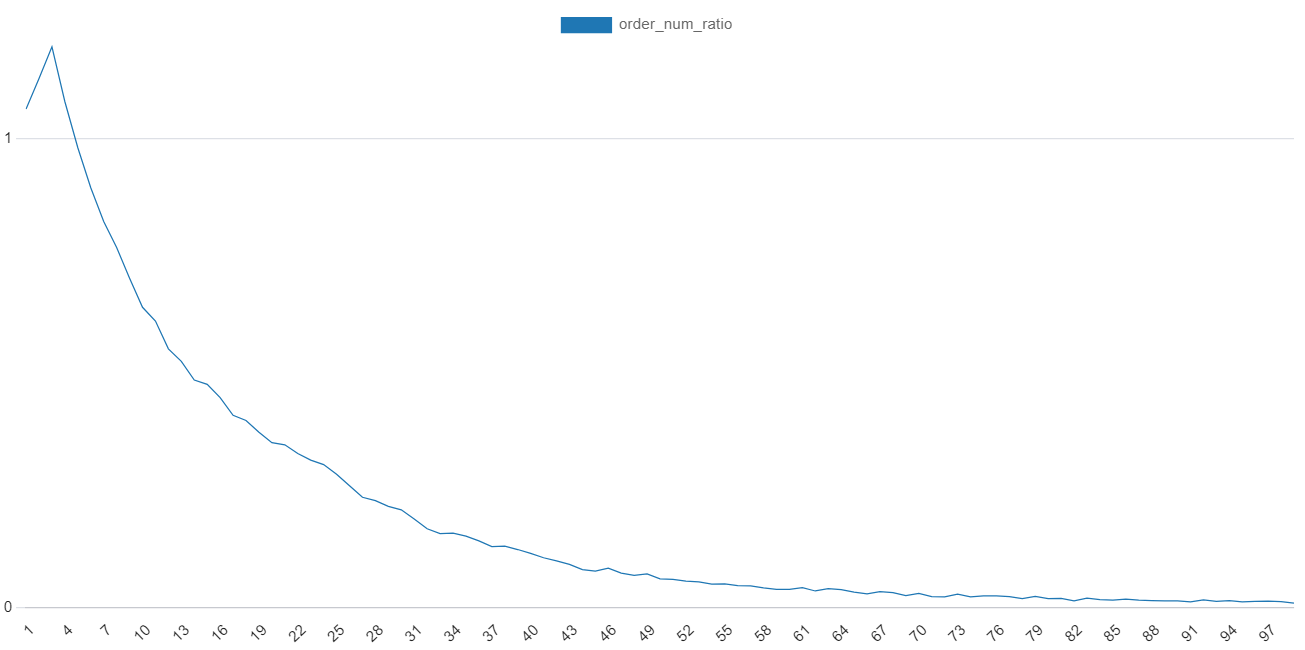

select order_number, 
      count(*)::float  / (select count(*) from "Ecommerce_Project".model_data) * 100 as order_num_ratio
from "Ecommerce_Project".model_data
where target = 1
group by order_number